CAPÍTULO 14 - Diagnóstico de modelos
-


Construir mdelos é uma arte contínua, conforme vamos adicionando e removendo variáveis de nossos modelos precisamos ter uma forma de compará=los de modo consistente e é isso que veremos neste capítulo

14.2 Resíduos

Os resíduos de um modelo comparam o que o modelo calcula com os valores propriamente ditos dos dados. Vamos adequar alguns modelos para um conjunto de dados de habitação.

In [145]:
import pandas as pd
housing = pd.read_csv('../../data/housing_renamed.csv')

print(housing.head())

  neighborhood            type  units  year_built   sq_ft    income  \
0    FINANCIAL  R9-CONDOMINIUM     42      1920.0   36500   1332615   
1    FINANCIAL  R4-CONDOMINIUM     78      1985.0  126420   6633257   
2    FINANCIAL  RR-CONDOMINIUM    500         NaN  554174  17310000   
3    FINANCIAL  R4-CONDOMINIUM    282      1930.0  249076  11776313   
4      TRIBECA  R4-CONDOMINIUM    239      1985.0  219495  10004582   

   income_per_sq_ft  expense  expense_per_sq_ft  net_income     value  \
0             36.51   342005               9.37      990610   7300000   
1             52.47  1762295              13.94     4870962  30690000   
2             31.24  3543000               6.39    13767000  90970000   
3             47.28  2784670              11.18     8991643  67556006   
4             45.58  2783197              12.68     7221385  54320996   

   value_per_sq_ft       boro  
0           200.00  Manhattan  
1           242.76  Manhattan  
2           164.15  Manhattan  
3     

In [146]:
#começaremos com um modelo de regressão linear múltipla com três covariantes

import statsmodels
import statsmodels.api as sum
import statsmodels.formula.api as smf

house1 = smf.glm('value_per_sq_ft ~ units + sq_ft + boro',
                 data=housing).fit()
print(house1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        value_per_sq_ft   No. Observations:                 2626
Model:                            GLM   Df Residuals:                     2619
Model Family:                Gaussian   Df Model:                            6
Link Function:               Identity   Scale:                          1879.5
Method:                          IRLS   Log-Likelihood:                -13621.
Date:                Sun, 30 Jun 2024   Deviance:                   4.9224e+06
Time:                        19:22:17   Pearson chi2:                 4.92e+06
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7772
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                43.29

Podemos plotar os resíduos de nosso modelo

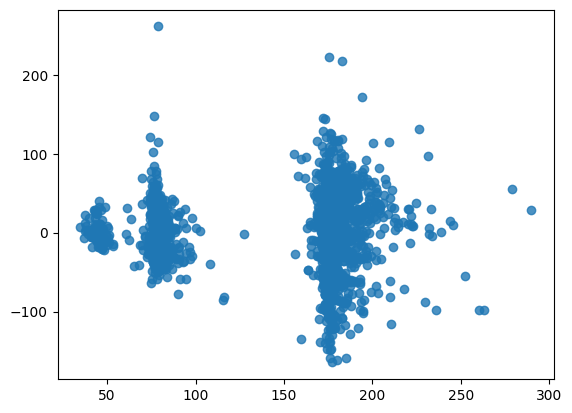

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax =plt.subplots()
ax = sns.regplot(x=house1.fittedvalues,
                 y=house1.resid_deviance, fit_reg=False)

plt.show()

Essa plotagem é preocupante pois contém clusters e grupos óbvios. Podemos colorir a plotagem de acordo com a variável boro que informa o bairro de nova york

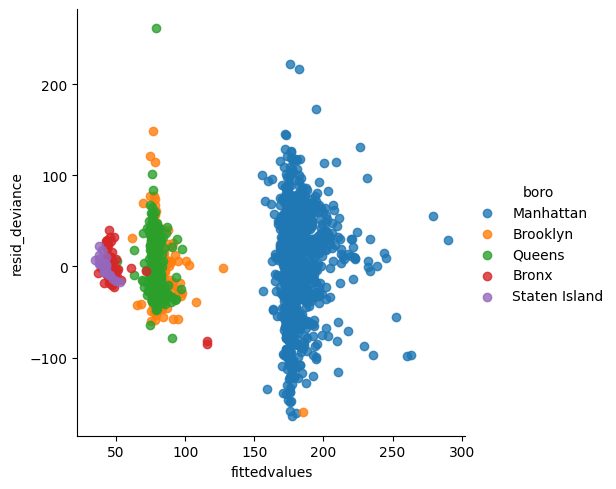

In [148]:
res_df = pd.DataFrame({
    'fittedvalues': house1.fittedvalues,
    'resid_deviance': house1.resid_deviance,
    
    'boro': housing['boro']
})

fig = sns.lmplot(x='fittedvalues', y='resid_deviance',
                 data=res_df, hue='boro', fit_reg=False)

plt.show()
fig.savefig('p5-ch-model_diagnostics/figures/resid_boros')

14.2.1 Plotagens q-q

plotagem q-q é uma técnica gráfica que determina se seus dados estão de acordo com a distribuição de refência. Muitos modelos supõem que os dados estejam normais, e uma plotagem q-q garante que seus dados sejam de fato normais

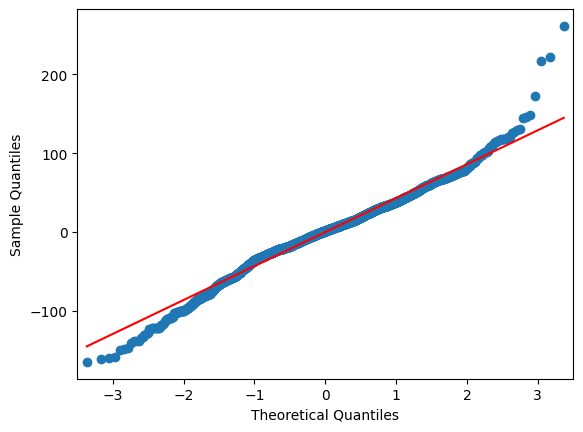

In [149]:
from scipy import stats
import statsmodels.graphics
import statsmodels.graphics.gofplots

resid = house1.resid_deviance.copy()
resid_std = stats.zscore(resid)

fig = statsmodels.graphics.gofplots.qqplot(resid, line='r')
plt.show()
fig.savefig('p5-ch-model_diagnostics/figures/house_1_qq')

Se os pontos na plotagem q-q estiverem na linha vermelha, é sinal de que os dados estão de acordo com nossa distribuição de referencia, se os pontos não estiverem na linha vermelha, podemos aplicar uma trabsformação em nossos dados   
A tabela 14.1 mostra transformações que podem ser feitas em nossos dados.

Podemos plotar um histograma dos resíduos para ver se nossos dados são normais

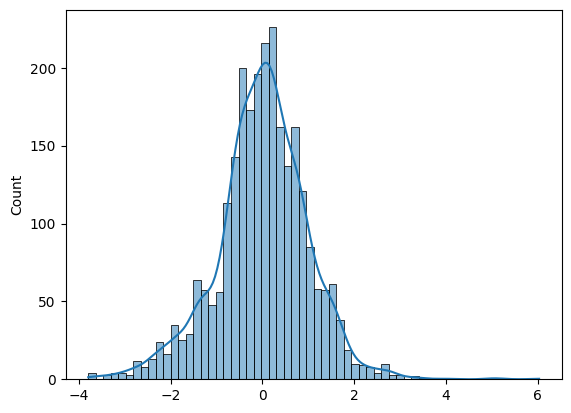

In [150]:
fig, ax = plt.subplots()
ax = sns.histplot(resid_std, kde=True)
plt.show()

14.3 Comparando vários modelos.

Agora que conseguimos avaliar um único modelo, precisamos comparar vários modelos para escolhermos o "melhor"

In [151]:
f1 = 'value_per_sq_ft ~ units + sq_ft + boro'
f2 = 'value_per_sq_ft ~ units * sq_ft + boro'
f3 = 'value_per_sq_ft ~ units + sq_ft * boro + type'
f4 = 'value_per_sq_ft ~ units + sq_ft * boro + sq_ft * type'
f5 = 'value_per_sq_ft ~ boro + type'

house1 = smf.ols(f1, data=housing).fit()
house2 = smf.ols(f2, data=housing).fit()
house3 = smf.ols(f3, data=housing).fit()
house4 = smf.ols(f4, data=housing).fit()
house5 = smf.ols(f5, data=housing).fit()

14.3.1 Trabalhando com modelos lineares

Um modo simples de calcular o desempenho do modelo é por meio do AIC (Akaike Information Criterior, ou Critério de Inoformação de Akaike) e do BIC (Bayesian Iformation Criterior, ou Critério de Informação Bayesian). Esses métodos aplicam uma penalidade para cada característica adicionada ao modelo. Assim devemos nos esforçar para que haja um equílibrio entre desempenho e parcimonia (quanto menor, melhor)

In [152]:
house_models = [house1, house2, house3, house4, house5]

model_names = ['house1', 'house2', 'house3', 'house4', 'house5']

house_aic = [model.aic for model in house_models]

house_bic = [model.bic for model in house_models]

In [153]:
#lembre-se que os dicionarios não são ordenados

abic = pd.DataFrame({'model': model_names,
                     'aic': house_aic,
                     'bic': house_bic})

print(abic)

    model           aic           bic
0  house1  27256.031113  27297.143632
1  house2  27237.939618  27284.925354
2  house3  27103.502577  27185.727615
3  house4  27084.800043  27184.644733
4  house5  27246.843392  27293.829128


14.3.2 Trabalhando com modelos GLM

Podemos fazer os mesmos cáculos e diagnosticos de modelos em GLMs. No entanto, a ANOVA é simplesmente o desvio do modelo

In [154]:
def anova_deviance_table(*models):
    return pd.DataFrame({
        'df_residuals': [i.df_resid for i in models],
        'resid_stddev': [i.deviance for i in models],
        'df': [i.df_model for i in models],
        'deviance': [i.deviance for i in models]
    })

In [155]:
f1 = 'value_per_sq_ft ~ units + sq_ft + boro'
f2 = 'value_per_sq_ft ~ units * sq_ft + boro'
f3 = 'value_per_sq_ft ~ units + sq_ft * boro + type'
f4 = 'value_per_sq_ft ~ units + sq_ft * boro + sq_ft * type'
f5 = 'value_per_sq_ft ~ boro + type'

glm1 = smf.ols(f1, data=housing).fit()
glm2 = smf.ols(f2, data=housing).fit()
glm3 = smf.ols(f3, data=housing).fit()
glm4 = smf.ols(f4, data=housing).fit()
glm5 = smf.ols(f5, data=housing).fit()

In [156]:
#glm_anova = anova_deviance_table(glm1, glm2, glm3, glm4, glm5)

14.4 Validação cruzada k-fold

A validação cruzada é outra técnica usada para comparar modelos. Uma das principais vantagens, é que leva em consideração o modelo de novos dados.

Nesse exemplo, separamos nossos dados em k - 1 conjuntos de dados teste e de treinamento

In [157]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

print(housing.columns)

Index(['neighborhood', 'type', 'units', 'year_built', 'sq_ft', 'income',
       'income_per_sq_ft', 'expense', 'expense_per_sq_ft', 'net_income',
       'value', 'value_per_sq_ft', 'boro'],
      dtype='object')


In [160]:
#obtém os dados de treinamento e de teste
X_train, X_test, y_train, y_test = train_test_split(
    pd.get_dummies(housing[['units', 'sq_ft', 'boro']],
                   drop_first=True),
    housing['value_per_sq_ft'],
    test_size=0.20,
    random_state=42
)

Podemos obter uma pontuação que informe o desempenho de nosso modelo usando nosso conjunto de teste.

In [162]:
lr = LinearRegression().fit(X_train, y_train)
print(lr.score(X_test, y_test))

0.6137125285030869


A biblioteca patsy nos permite especificar uma fórmula, como na API de fórmula da stats models, e devolve uma array numpy apropriado que pode ser usado na sklearn

In [164]:
from patsy import dmatrices

y, X = dmatrices('value_per_sq_ft ~ units + sq_ft + boro', housing,
                 return_type="dataframe")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)
lr = LinearRegression().fit(X_train, y_train)
print(lr.score(X_test, y_test))

0.6137125285025644


Para fazer uma validação cruzada k-fold, é necessário importar essa função da sklearn.

In [165]:
from sklearn.model_selection import KFold, cross_val_score

housing = pd.read_csv('../../data/housing_renamed.csv')

Agora temos de especificar quantas partes (folds) queremos. Esse numero depende da quantidade de linhas que você tiver, se os dados não possuirem muitas observações será possivel selecionar um numero menor de k (exemplo, 2). Normalmente se usa entre 5 e 10, mas tenha em mente que valores maiores de k exigirão mais tempo de processamento

In [166]:
kf = KFold(n_splits=5)

y, X = dmatrices('value_per_sq_ft ~ units + sq_ft + boro', housing)

In [168]:
#Em seguida podemos treinar e testar nosso modelo em cada parte

coefs = []
scores = []
for train, test in kf.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    lr = LinearRegression().fit(X_train, y_train)
    coefs.append(pd.DataFrame(lr.coef_))
    scores.append(lr.score(X_test, y_test))

In [171]:
#também podemos vizualizar os resultados
coefs_df = pd.concat(coefs)
coefs_df.columns = X.design_info.column_names
coefs_df

,Intercept,boro[T.Brooklyn],boro[T.Manhattan],boro[T.Queens],boro[T.Staten Island],units,sq_ft
0,0.0,33.369037,129.904011,32.103100,-4.381085e+00,-0.205890,0.000220
0,0.0,32.889925,116.957385,31.295956,-4.919232e+00,-0.146180,0.000155
0,0.0,30.975560,141.859327,32.043449,-4.379916e+00,-0.179671,0.000194
0,0.0,41.449196,130.779013,33.050968,-3.430209e+00,-0.207904,0.000232
0,0.0,-38.511915,56.069855,-17.557939,-1.065814e-14,-0.145829,0.000202


O coeficiente médio pode ser vizualizado em todas as partes usando apply e a função np.mean

In [172]:
import numpy as np 

print(coefs_df.apply(np.mean))

Intercept                  0.000000
boro[T.Brooklyn]          20.034361
boro[T.Manhattan]        115.113918
boro[T.Queens]            22.187107
boro[T.Staten Island]     -3.422088
units                     -0.177095
sq_ft                      0.000201
dtype: float64


In [173]:
print(scores)

[0.02731416290641886, -0.5538362212407846, -0.15636371688048611, -0.32342020619290723, -1.6929655586930368]


cross_val_scores também pode ser usado para calcular nossas pontuações

In [174]:
model = LinearRegression()
scores = cross_val_score(model, X, y, cv=5)
print(scores)

[ 0.02731416 -0.55383622 -0.15636372 -0.32342021 -1.69296556]


In [175]:
#se fôssemos comparar vários modelos entre si, compararíamos a média das pontuações
print(scores.mean())

-0.5398543080201591


Agora vamos fazer a readequação de nossos modelos usando a validação cruzada k-fold

In [176]:
y1, X1 = dmatrices('value_per_sq_ft ~ units + sq_ft + boro',housing)
y2, X2 = dmatrices('value_per_sq_ft ~ units * sq_ft + boro',housing)
y3, X3 = dmatrices('value_per_sq_ft ~ units + sq_ft * boro + type',housing)
y4, X4 = dmatrices('value_per_sq_ft ~ units + sq_ft * boro + sq_ft * type',housing)
y5, X5 = dmatrices('value_per_sq_ft ~ boro + type',housing)

Faz adequação de nossos modelos

In [177]:
scores1 = cross_val_score(model, X1, y1, cv=5)
scores2 = cross_val_score(model, X2, y2, cv=5)
scores3 = cross_val_score(model, X3, y3, cv=5)
scores4 = cross_val_score(model, X4, y4, cv=5)
scores5 = cross_val_score(model, X5, y5, cv=5)

Podemos observar agora nossar pontuações de validação cruzada

In [178]:
scores_df = pd.DataFrame([scores1, scores2, scores3, scores4, scores5])

print(scores_df.apply(np.mean, axis=1))

0   -5.398543e-01
1   -1.088184e+00
2   -3.569802e+26
3   -1.109403e+27
4   -3.179433e+25
dtype: float64


Mais uma vez podemos ver que o modelo 4 apresenta melhor desenpenho.